In [ ]:
!rm -rf /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/Habiba Ishfaq/Task1"



celeba_models


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"habibaishfaq","key":"7f2eeab562981218ec8ee5c5915a7954"}'}

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!mv kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d jessicali9530/celeba-dataset


Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
 99% 1.32G/1.33G [00:06<00:00, 245MB/s]
100% 1.33G/1.33G [00:06<00:00, 224MB/s]


In [ ]:
!unzip -q celeba-dataset.zip -d celeba


In [ ]:
!ls -lh /content/celeba


total 42M
drwxr-xr-x 3 root root 4.0K Jul 27 18:38 img_align_celeba
-rw-r--r-- 1 root root  24M Oct  1  2019 list_attr_celeba.csv
-rw-r--r-- 1 root root 5.2M Oct  1  2019 list_bbox_celeba.csv
-rw-r--r-- 1 root root 2.8M Oct  1  2019 list_eval_partition.csv
-rw-r--r-- 1 root root 9.5M Oct  1  2019 list_landmarks_align_celeba.csv


In [ ]:
import os

img_dir = '/content/celeba/img_align_celeba/img_align_celeba'
image_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]
attr_file = '/content/celeba/list_attr_celeba.csv'

print(f"Total face images: {len(image_files)}")
print(f"Attributes file exists: {os.path.exists(attr_file)}")



Total face images: 202599
Attributes file exists: True


In [ ]:
# Install packages
!pip install mtcnn tensorflow keras opencv-python matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.1 MB/s eta 0:00:00


In [ ]:
# Imports
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mtcnn import MTCNN
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import random
import os


In [ ]:
with open(attr_file) as f:
    lines = f.readlines()
attr_names = lines[1].strip().split()
print(attr_names[:10])  # print first 10 to inspect


['000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1,-1,1,-1,-1,1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,1']


In [ ]:


# Set paths
img_dir = '/content/celeba/img_align_celeba/img_align_celeba'
attr_file = '/content/celeba/list_attr_celeba.csv'

# Load the attributes file with pandas
df = pd.read_csv(attr_file)

# Show first few columns to verify
print("First few columns of the DataFrame:")
print(df.head())

# Convert the attributes from -1/1 to binary 0/1
df['Male'] = (df['Male'] == 1).astype(int)  # (0: Female, 1: Male)
df['Eyeglasses'] = (df['Eyeglasses'] == 1).astype(int)  # (0: No Glasses, 1: Glasses)

# Optionally rename image_id to filename
df.rename(columns={'image_id': 'filename'}, inplace=True)

# Create filtered data list
filtered_data = list(zip(df['filename'], df['Male'], df['Eyeglasses']))

# Print
print(f" Total face images found in directory: {len(os.listdir(img_dir))}")
print(f" Total labeled samples in attributes file: {len(filtered_data)}")
print(" Sample records:")
for record in filtered_data[:5]:
    print(record)


First few columns of the DataFrame:
     image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
0  000001.jpg                -1                1           1               -1   
1  000002.jpg                -1               -1          -1                1   
2  000003.jpg                -1               -1          -1               -1   
3  000004.jpg                -1               -1           1               -1   
4  000005.jpg                -1                1           1               -1   

   Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  Sideburns  Smiling  \
0    -1     -1        -1        -1          -1  ...         -1        1   
1    -1     -1        -1         1          -1  ...         -1        1   
2    -1     -1         1        -1          -1  ...         -1       -1   
3    -1     -1        -1        -1          -1  ...         -1       -1   
4    -1     -1         1        -1          -1  ...         -1       -1   

   Straight_Hair  Wavy_Hai

In [ ]:
# Initialize face detector
detector = MTCNN()


In [ ]:
# Preprocessing function - detect face, crop, resize, normalize
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = detector.detect_faces(img_rgb)
    if len(results) == 0:
        return None
    x, y, w, h = results[0]['box']
    x, y = max(0, x), max(0, y)
    face = img_rgb[y:y+h, x:x+w]
    face = cv2.resize(face, (128, 128))
    face = face / 255.0
    return face


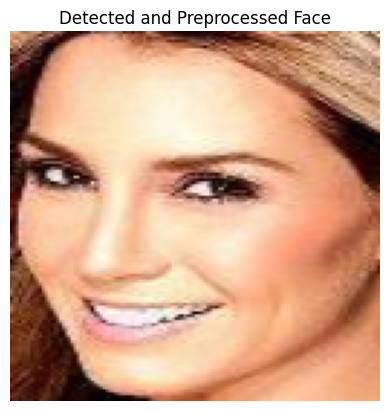

In [ ]:
# Visualize sample
sample_file = filtered_data[0][0]
sample_path = os.path.join(img_dir, sample_file)
face_img = preprocess_image(sample_path)

if face_img is not None:
    plt.imshow(face_img)
    plt.title('Detected and Preprocessed Face')
    plt.axis('off')
    plt.show()
else:
    print("Face not detected in sample.")


In [ ]:
# Data generator yields batches of faces and labels
def data_generator(data, batch_size=32, img_dir=img_dir):
    while True:
        batch_samples = random.sample(data, batch_size)
        faces = []
        genders = []
        glasses = []
        for filename, gender, glass in batch_samples:
            face = preprocess_image(os.path.join(img_dir, filename))
            if face is None:
                continue
            faces.append(face)
            genders.append(gender)
            glasses.append(glass)
        if len(faces) == 0:
            continue
        yield np.array(faces), {'gender_output': np.array(genders), 'glasses_output': np.array(glasses)}


In [ ]:
# Model building
def build_multi_output_model(input_shape=(128,128,3)):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    gender_output = Dense(1, activation='sigmoid', name='gender_output')(x)
    glasses_output = Dense(1, activation='sigmoid', name='glasses_output')(x)
    model = Model(inputs=base_model.input, outputs=[gender_output, glasses_output])
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss={'gender_output': 'binary_crossentropy',
                        'glasses_output': 'binary_crossentropy'},
                  metrics={'gender_output': 'accuracy',
                           'glasses_output': 'accuracy'})
    return model

model = build_multi_output_model()
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Training
steps_per_epoch = 100
epochs = 5

history = model.fit(data_generator(filtered_data, batch_size=32),
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs)


Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 572s 6s/step - gender_output_accuracy: 0.6548 - gender_output_loss: 0.6214 - glasses_output_accuracy: 0.9271 - glasses_output_loss: 0.2372 - loss: 0.8584
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 572s 6s/step - gender_output_accuracy: 0.8477 - gender_output_loss: 0.3540 - glasses_output_accuracy: 0.9720 - glasses_output_loss: 0.0930 - loss: 0.4472
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 568s 6s/step - gender_output_accuracy: 0.8670 - gender_output_loss: 0.3219 - glasses_output_accuracy: 0.9737 - glasses_output_loss: 0.0792 - loss: 0.4009
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 569s 6s/step - gender_output_accuracy: 0.8644 - gender_output_loss: 0.3065 - glasses_output_accuracy: 0.9766 - glasses_output_loss: 0.0610 - loss: 0.3674
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 566s 6s/step - gender_output_accuracy: 0.8786 - gender_output_loss: 0.2978 - glasses_output_accuracy: 0.9841 - glasses_output_loss: 0.0479 - loss: 0.3457


In [ ]:
# Save model
model.save('/content/drive/MyDrive/Habiba Ishfaq/Task1/celeba_models/gender_glasses_model.h5')
print(" Model saved successfully in celeba_models!")



 Model saved successfully in celeba_models!


In [ ]:
def detect_shirt_color(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return "Image error"
    h, w = img.shape[:2]
    shirt_area = img[int(0.6*h):h, int(0.3*w):int(0.7*w)]
    avg_color = cv2.mean(shirt_area)[:3]
    colors = ['Red', 'Green', 'Blue', 'White', 'Black']
    if max(avg_color) < 50: return 'Black'
    if min(avg_color) > 200: return 'White'
    dominant = np.argmax(avg_color)
    return colors[dominant]


In [ ]:
def detect_features(img_path, model):
    face = preprocess_image(img_path)
    if face is None:
        return 'Face Not Found', 'N/A', 'N/A'
    face = np.expand_dims(face, axis=0)
    gender_pred, glasses_pred = model.predict(face)
    gender = 'Male' if gender_pred[0][0] > 0.5 else 'Female'
    glasses = 'Yes' if glasses_pred[0][0] > 0.5 else 'No'
    shirt_color = detect_shirt_color(img_path)
    return gender, glasses, shirt_color


In [ ]:
from tensorflow.keras.models import Model, load_model
model_path = '/content/drive/MyDrive/Habiba Ishfaq/Task1/celeba_models/gender_glasses_model.h5'
model = load_model(model_path)


In [ ]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
    gender, glasses, shirt = detect_features(fn, model)
    print(f"\n👤 Gender: {gender}")
    print(f"🕶️ Glasses: {glasses}")
    print(f"👕 Shirt Color: {shirt}")

    img = cv2.imread(fn)
    if img is not None:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("Uploaded Image")
        plt.show()
    else:
        print("Image could not be displayed.")
